## Imports

In [5]:
import dostools
import importlib
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import time
import matplotlib
torch.set_default_dtype(torch.float64) 
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 10)
sys.modules['dostools.src'] = dostools

In [6]:
import dostools.datasets.data as data
import dostools.utils.utils as utils

n_structures = 1039
np.random.seed(0)
n_train = int(0.8 * n_structures)
train_index = np.arange(n_structures)
np.random.shuffle(train_index)
test_index = train_index[n_train:]
train_index = train_index[:n_train]

with torch.no_grad():
    structures = data.load_structures(":")
    n_structures = len(structures) #total number of structures
    for structure in structures:#implement periodicity
        structure.wrap(eps = 1e-12) 
    n_atoms = np.zeros(n_structures, dtype = int) #stores number of atoms in each structures
    for i in range(n_structures):
        n_atoms[i] = len(structures[i])

    #eigenergies, emin, emax = dostools.src.datasets.data.load_eigenenergies(unpack = True, n_structures = len(structures))
    xdos = torch.tensor(data.load_xdos())
    ldos = torch.tensor(data.load_ldos())
    ldos *= 2

    print ("ldos shape is {}".format(ldos.shape))
    mean_dos_per_atom = ldos[train_index].mean(axis = 0) #only calculated for train set to prevent data leakage
    print ("mean dos shape is {}".format(mean_dos_per_atom.shape))
    
    
    y_pw = ldos - mean_dos_per_atom
    y_lcdf = torch.cumsum(y_pw, dim = 1)
    _, pc_vectors = utils.build_pc(ldos[train_index], mean_dos_per_atom[None,:], n_pc = 10)
    y_pc = utils.build_coeffs(ldos - mean_dos_per_atom[None,:], pc_vectors)
    Silicon = data.load_features()
    kMM = data.load_kMM()

ldos shape is torch.Size([1039, 778])
mean dos shape is torch.Size([778])
Variance covered with 10 PCs is = 0.9871211778950163


## Evaluator

In [7]:
import dostools.evaluation.evaluation as evaluation
importlib.reload(evaluation)
import dostools.models.training as training
importlib.reload(training)

targets = {
    'pw' : ldos,
    'lcdf' : y_lcdf,
    'pc' : y_pc
}
evaluator = evaluation.Evaluator(targets, xdos, mean_dos_per_atom)

## Dataset and DataLoader

In [8]:
from torch.utils.data import Dataset

class AtomicDataset(Dataset):
    def __init__(self, X, y, n_atoms_per_structure):
        self.X = X
        self.y = y
        self.n_structures = len(n_atoms_per_structure)
        self.n_atoms_per_structure = n_atoms_per_structure
        self.index = self.generate_atomstructure_index(self.n_atoms_per_structure)

    def __len__(self):
        return self.n_structures

    def __getitem__(self, idx, E):
        if type(idx) == list:
            x_indexes = []
            
            for i in idx:                
                x_indexes.append((self.index == i).nonzero(as_tuple = True)[0])
                
            x_indexes = torch.hstack(x_indexes)
            return self.X[x_indexes], self.y[idx, y_index], self.generate_atomstructure_index(self.n_atoms_per_structure[idx])
                
        else:
            x_indexes = (self.index == idx).nonzero(as_tuple = True)[0]
            return (self.X[x_indexes], self.y[idx], self.n_atoms_per_structure[idx])

    def generate_atomstructure_index(self, n_atoms_per_structure):
        n_structures = len(n_atoms_per_structure)
        total_index = []
        for i, atoms in enumerate(n_atoms_per_structure):
            indiv_index = torch.zeros(atoms) + i
            total_index.append(indiv_index)
        total_index = torch.hstack(total_index)
        return total_index.long()

In [9]:
from torch.utils.data import DataLoader, BatchSampler, RandomSampler, SubsetRandomSampler

def collate(batch):
    for x, y, index in batch:
        return (x, y ,index)

test = AtomicDataset(torch.vstack(Silicon.Features['structure_descriptors'][:1]).double(), ldos[:1].double(), n_atoms[:1])   

device = 'cpu'
kwargs = {"pin_memory":True} if device == "cuda:0" else {}


Sampler = RandomSampler(test)
BSampler = BatchSampler(Sampler, batch_size = 32, drop_last = False)

dataloader = DataLoader(test, sampler = BSampler, shuffle = False, collate_fn = collate, **kwargs)



In [33]:
[5] * 5

[5, 5, 5, 5, 5]

In [49]:
from torch.utils.data import Dataset

class AtomicEnergywiseDataset(Dataset):
    def __init__(self, X, y, xdos, n_atoms_per_structure):
#         self.X = torch.hstack([X.repeat_interleave(xdos.size()[0], dim = 0), xdos.view(-1,1).repeat(X.size()[0],1)])
        self.X = X
        self.xdos = xdos
        self.xdos_step = xdos[1]-xdos[0]
        self.y = y
        self.n_structures = len(n_atoms_per_structure)
        self.n_atoms_per_structure = n_atoms_per_structure
        self.index = self.generate_atomstructure_index(self.n_atoms_per_structure)

    def __len__(self):
        return self.n_structures

    def __getitem__(self, idxE):
        if type(idxE) == list:
            x_indexes = []
            y_indexes = []
            E_stack = []
            n_atoms = []
            S_list = []
            for S,E in (idxE):                
                x_indexes.append((self.index == S).nonzero(as_tuple = True)[0])
                y_indexes.append(torch.round((E - self.xdos[0])/self.xdos_step).int())
                E_stack.append(torch.zeros(self.n_atoms_per_structure[S]) + E)#[E] * self.n_atoms_per_structure[S])
                n_atoms.append(self.n_atoms_per_structure[S])
                S_list.append([S] * self.n_atoms_per_structure[S])
            x_indexes = torch.hstack(x_indexes)
            xdos_stack = torch.hstack(E_stack).view(-1,1)
            S_list = sum(S_list, [])
            #xdos_stack = torch.tensor(E_stack).view(-1,1)
            return torch.hstack([self.X[x_indexes], xdos_stack]), self.y[S, y_indexes], self.generate_atomstructure_index(n_atoms), torch.tensor(S_list)
                
        else:
            idx, E = idxE
            E = torch.tensor(E)
            y_indexes = [torch.round((x - self.xdos[0])/self.xdos_step) for x in E]
            x_index = (self.index == idx).nonzero(as_tuple = True)[0]
            return (self.X[x_index], self.y[idx, y_indexes], self.n_atoms_per_structure[idx])
    
    
    def generate_atomstructure_index(self, n_atoms_per_structure):
        n_structures = len(n_atoms_per_structure)
        total_index = []
        for i, atoms in enumerate(n_atoms_per_structure):
            indiv_index = torch.zeros(atoms) + i
            total_index.append(indiv_index)
        total_index = torch.hstack(total_index)
        return total_index.long()

In [50]:
from torch.utils.data import DataLoader, BatchSampler, RandomSampler, SubsetRandomSampler, SequentialSampler

def collate(batch):
    for x, y, index, S_list in batch:
        return (x, y ,index, S_list)

atomic_train = AtomicEnergywiseDataset(torch.vstack(list(np.array(Silicon.Features['structure_descriptors'])[train_index[:100]])).double(), y_pw[train_index[:10]].double(), xdos, n_atoms[train_index[:10]])   

device = 'cpu'
kwargs = {"pin_memory":True} if device == "cuda:0" else {}

#indices must go over structures and energy values

SE_indices = []
for s in range(len(atomic_train)):
    for e in xdos:
        SE_indices.append((s,e.item()))

critical_indexes = np.array([1,2,3,4,5,6,7,8])
critical_index = []
for s in critical_indexes:
    for e in xdos:
        critical_index.append((s,e.item()))

        
        
SESampler = SubsetRandomSampler(SE_indices)
#SQSampler = SequentialSampler(critical_index)

BSampler = BatchSampler(SESampler, batch_size = 2056, drop_last = False)

dataloader = DataLoader(atomic_train, sampler = BSampler, shuffle = False, collate_fn = collate, **kwargs)

# SQSampler = SequentialSampler(critical_index)
# BSQSampler = BatchSampler(SQSampler, batch_size = len(critical_index), drop_last = False)
# critical_dataloader = DataLoader(atomic_train, sampler = BSQSampler, shuffle = False, collate_fn = collate, **kwargs)


/tmp/ipykernel_4882/3272996337.py:7: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  atomic_train = AtomicEnergywiseDataset(torch.vstack(list(np.array(Silicon.Features['structure_descriptors'])[train_index[:100]])).double(), y_pw[train_index[:10]].double(), xdos, n_atoms[train_index[:10]])
/tmp/ipykernel_4882/3272996337.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray

## Loss Function

In [53]:
import dostools.consistency.consistency as consistency
import dostools.loss.loss as loss
importlib.reload(loss)
importlib.reload(consistency)

def t_get_mse(a, b, xdos = None, perc = False):
    if xdos is not None:
        mse = (torch.trapezoid((a - b)**2, xdos, axis=1)).mean()
        if not perc:
            return mse
        else:
            mean = b.mean(axis = 0)
            std = torch.sqrt(torch.trapezoid((b - mean)**2, xdos, axis=1)).mean()
            return (100 * mse / std)
    else:
        mse = ((a - b)**2).mean(dim = 1)
        if len(mse.shape) > 1:
            raise ValueError('Loss became 2D')
        if not perc:
            return torch.mean(mse, 0)
        else:
            return torch.mean(100 * (mse / b.std(dim=0, unbiased = True)),0)


## Evaluation Function

In [54]:
def t_get_mse(a, b, xdos = None, perc = False):
    if xdos is not None:
        mse = (torch.trapezoid((a - b)**2, xdos, axis=1)).mean()
        if not perc:
            return mse
        else:
            mean = b.mean(axis = 0)
            std = torch.sqrt(torch.trapezoid((b - mean)**2, xdos, axis=1)).mean()
            return (100 * mse / std)
    else:
        try:
            mse = ((a - b)**2).mean(dim = 1)
            
        except:
            mse = ((a - b)**2)
        if len(mse.shape) > 1:
            raise ValueError('Loss became 2D')
        if not perc:
            return torch.mean(mse, 0)
        else:
            return torch.mean(100 * (mse / b.std(dim=0, unbiased = True)),0)


## NN Model

In [55]:
import dostools.src.models.models as models
import dostools.src.models.training as training
import dostools.src.models.architectures as architecture
import dostools.src.loss.loss as loss
import torch.nn as nn

importlib.reload(models)
importlib.reload(training)
importlib.reload(architecture)
importlib.reload(loss)



class CDNN(torch.nn.Module):
    
    def __init__(self, input_dims, L1, L2, target_dims, xdos, dropout, reg, opt, device):
        super(CDNN, self).__init__()
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.fc1 = torch.nn.Linear(input_dims + 1, L1)
        self.fc2 = torch.nn.Linear(L1,L2)
        self.fc3 = torch.nn.Linear(L2, target_dims)
        self.silu = torch.nn.SiLU()
        self.param=torch.nn.parameter.Parameter(torch.ones(10))
        self.xdos = xdos
        #self.dropout = torch.nn.Dropout(p = dropout)
        self.device = device
        self.reg = torch.tensor(reg).to(self.device)
        self.opt = opt
        self.to(self.device)
        
    def forward(self, x):
        
        #results = []
        #for i, E in enumerate(torch.nn.functional.normalize(self.xdos, dim =0)):
            #result = self.fc1(torch.hstack([x,(E*100).repeat(x.shape[0])[:,None]]))
        #for i, E in enumerate(self.xdos):   
        
        result = self.fc1(x)
        result = self.silu(result)
        result = self.fc2(result)
        result = self.silu(result)
        result = self.fc3(result)
        #result = self.silu(result)
        #results.append(result)
        #results = torch.hstack(results)
        return result
    
#     def fit(self, traindata_loader, valdata_loader, loss, lr ,n_epochs):
#         """
#         Fits the model based on the training data, early stopping is based on performance on training data (or validation data)
#         Returns the loss history 
        
#         Args:
#             traindata_loader (DataLoader): Train dataloader
#             valdata_loader (DataLoader): Validation dataloader
#             loss (function): Loss function
#             lr (float): Learning rate
#             n_epochs (int): Max number of epochs
        
#         Returns:
#             list: Loss history of the training process
#         """
#         if self.opt == "Adam":
#             opt = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = self.reg.item())
#             if valdata_loader is not None:
#                 threshold = 3000
#                 scheduler_threshold = 1000
#             else:
#                 threshold = 200
#                 scheduler_threshold = 100
#             tol = 1e-10
# #         if self.opt == "LBFGS":
# #             opt = torch.optim.LBFGS(self.parameters(), lr = lr)
# #             if valdata_loader is not None:
# #                 threshold = 2000
# #                 scheduler_threshold = 2000
# #             else:
# #                 threshold = 30
# #                 scheduler_threshold = 25
# #             tol = 1e-2
#         scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = scheduler_threshold)#0.5)
#         best_state = copy.deepcopy(self.state_dict())
#         lowest_loss = torch.tensor(9999)
#         pred_loss = torch.tensor(0)
#         trigger = 0
#         loss_history =[]
#         pbar = tqdm(range(n_epochs))
#         fig, ax_list = plt.subplots(4,2)
#         ax_list = ax_list.flatten()
#         ax_list.flatten()
#         lines = []
#         for i in range(8):
#             line, = ax_list[i].plot(self.xdos.cpu(), traindata_loader.dataset.y[i], label = "Prediction")
#             lines.append(line)
#             ax_list[i].plot(self.xdos.cpu(), traindata_loader.dataset.y[i], label = "True")
#         ax_list[0].legend()
#         fig.show()
#         for epoch in pbar:
#             pbar.set_postfix(pred_loss = pred_loss.item(), lowest_loss = lowest_loss.item(), trigger = trigger)
#             self.train()          
#             if self.opt == "Adam":
#                 opt.zero_grad()                
#                 for x_data, y_data, index in traindata_loader:
#                     pred = self.forward(x_data.view(-1,1))                    
#                     #structure_results = torch.sum(pred, dim = 0)
#                     structure_results = torch.zeros_like(y_data.view(-1,1))#.to(self.device)
#                     structure_results = structure_results.index_add_(0, index, pred)
#                     pred_loss = loss(structure_results, y_data.view(-1,1))
# #                     new_loss = pred_loss
#                     pred_loss = pred_loss# * 1000
#                     pred_loss.backward()
#                     opt.step()
#                 if pred_loss >100000 or (pred_loss.isnan().any()) :
#                     print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
#                     self.load_state_dict(best_state)
#                     opt = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = self.reg.item())
#                 if epoch %3 == 1:
#                     loss_history.append(lowest_loss.item())

                
#             with torch.no_grad():
#                 self.eval()
#                 if valdata_loader is not None:                
#                     new_loss = torch.zeros(1, requires_grad = False).to(self.device)
#                     for x_val, y_val in valdata_loader:
#                         x_val, y_val = x_val.to(self.device), y_val.to(self.device)
#                         val_pred = self.forward(x_val)
#                         new_loss += loss(val_pred, y_val, self.xdos, perc = False)
#                 else:
#                     eval_loss = 0
#                     dos_pred = []
#                     xdos_pred = []
#                     for x_data, y_data , index in dataloader: #only for 1 structure
#                         pred = model.forward(x_data.view(-1,1))   
#                         structure_results = torch.zeros_like(y_data.view(-1,1))#.to(self.device)
#                         structure_results = structure_results.index_add_(0, index, pred)
#                         eval_loss += loss(structure_results, y_data.view(-1,1))
                        
                    
#                         dos_pred.append(structure_results)
#                         xdos_pred.append(x_data[::2,-1])
#                     a = torch.vstack(dos_pred)
#                     b = torch.hstack(xdos_pred)
#                     _, indices = torch.sort(b)
#                     p_dos = a[indices]
#                     new_loss = loss(p_dos.view(-1,1), y_pw[0].view(-1,1))
#                     scheduler.step(new_loss)
#                     for i in range(1):
#                         #lines[i].set_ydata(structure_results[i].detach().cpu())
#                         lines[i].set_ydata(p_dos)
#                     ax_list[0].set_title("Epochs: {}, Pred loss: {}, Lowest loss:{}, Trigger: {}".format(epoch, pred_loss.item(), lowest_loss.item(), trigger))
#                     fig.canvas.draw()
#                     fig.canvas.flush_events()
#                     fig.show()
#                     #time.sleep(0.1)
#                 if lowest_loss - new_loss > tol: #threshold to stop training
#                     best_state = copy.deepcopy(self.state_dict())
#                     lowest_loss = new_loss
#                     trigger = 0

        
#                 else:
#                     trigger +=1
#                     if trigger > threshold:
#                         self.load_state_dict(best_state)
#                         print ("Implemented early stopping with lowest_loss: {}".format(lowest_loss))
#                         return loss_history
#         return loss_history  

In [57]:
# %matplotlib notebook
#plt.ion()

model = CDNN(448, 100, 100, 1, xdos, 0, 0, "Adam", "cpu")
#losshistory = model.fit(dataloader, None, t_get_mse, 0.001 ,1000000)

  0%|                                                                                                                                                                          | 0/1000000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


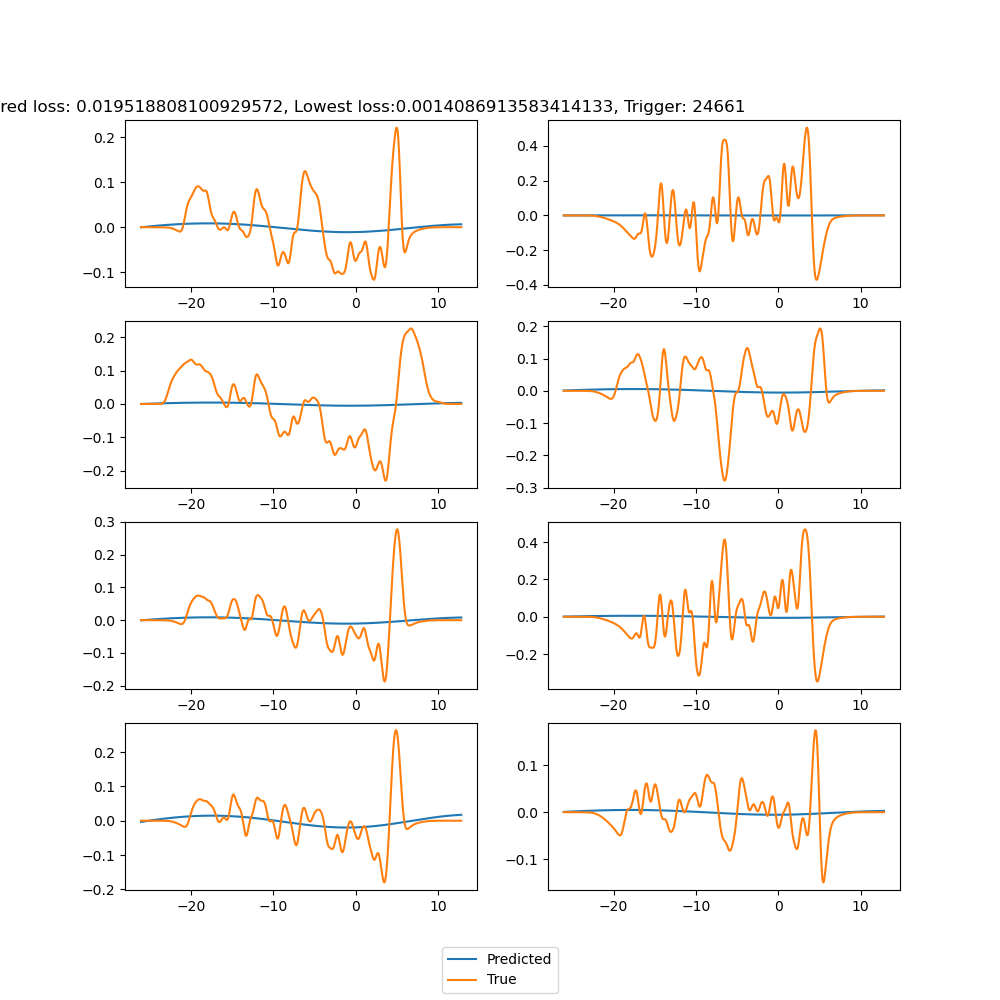

  9%|████████▉                                                                                      | 93549/1000000 [120:53:23<1171:22:22,  4.65s/it, lowest_loss=0.00141, pred_loss=0.0195, trigger=24662]


KeyboardInterrupt: 

In [62]:
traindata_loader = dataloader
lr = 0.001
n_epochs = 1000000


opt = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = model.reg.item())
threshold = 2000
scheduler_threshold = 1000
tol = 1e-10

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.5, patience = scheduler_threshold)
best_state = copy.deepcopy(model.state_dict())
lowest_loss = torch.tensor(9999)
pred_loss = torch.tensor(0)
trigger = 0
loss_history =[]
pbar = tqdm(range(n_epochs))
fig, ax_list = plt.subplots(4,2)
critical_indexes = np.array([1,2,3,4,5,6,7,8])
#critical_indexes = np.array([369, 341, 745, 521, 278, 5, 193, 37])
ax_list = ax_list.flatten()
ax_list.flatten()
lines = []
for i in range(len(critical_indexes)):
    line, = ax_list[i].plot(model.xdos.cpu(), traindata_loader.dataset.y[i], label = "Prediction")
    lines.append(line)
    ax_list[i].plot(model.xdos.cpu(), traindata_loader.dataset.y[i], label = "True")
fig.legend(labels = ["Predicted", "True"], loc = "lower center")
fig.show()
for epoch in pbar:
    pbar.set_postfix(pred_loss = pred_loss.item(), lowest_loss = lowest_loss.item(), trigger = trigger)
    model.train()
    opt.zero_grad()
    total_loss = 0
    for x_data, y_data, index, S_list in traindata_loader:
        x_data[:,-1] = x_data[:,-1] + model.param[S_list.long()]
        pred = model.forward(x_data)                    
        #structure_results = torch.sum(pred, dim = 0)
        structure_results = torch.zeros_like(y_data.view(-1,1))#.to(self.device)
        structure_results = structure_results.index_add_(0, index, pred)
        pred_loss = loss.t_get_mse(structure_results, y_data.view(-1,1))
        total_loss += pred_loss
        new_loss = pred_loss
        pred_loss = pred_loss #* 1000
        pred_loss.backward()
        opt.step()
        
    if new_loss >100000 or (new_loss.isnan().any()) :
        print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
        model.load_state_dict(best_state)
        for param_group in opt.param_groups:
            lr = param_group['lr']
        opt = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = model.reg.item())
    if epoch %3 == 1:
        loss_history.append(lowest_loss.item())

    scheduler.step(total_loss)
    
    with torch.no_grad():
        model.eval()
        #Calculating 8 critical indexes
        x, y, index, S_list = atomic_train[critical_index]
        x[:,-1] = x[:,-1] + model.param[S_list.long()]
        pred = model.forward(x)   
        structure_results = torch.zeros_like(y.view(-1,1))#.to(self.device)
        structure_results = structure_results.index_add_(0, index, pred)
        #eval_loss = loss.t_get_mse(structure_results, y.view(-1,1))
        structure_results = structure_results.reshape(8,778)
        
        for i in range(len(critical_indexes)):
            #lines[i].set_ydata(structure_results[i].detach().cpu())
            lines[i].set_ydata(structure_results[i])
        ax_list[0].set_title("Epochs: {}, Pred loss: {}, Lowest loss:{}, Trigger: {}".format(epoch, new_loss.item(), lowest_loss.item(), trigger))
        fig.canvas.draw()
        fig.canvas.flush_events()
        #fig.show()
        #time.sleep(0.1)
        if lowest_loss - new_loss > tol: #threshold to stop training
            best_state = copy.deepcopy(model.state_dict())
            lowest_loss = new_loss
            trigger = 0


        else:
            trigger +=1
#             if trigger > threshold:
#                 model.load_state_dict(best_state)
#                 print ("Implemented early stopping with lowest_loss: {}".format(lowest_loss))


In [28]:
x_data.shape

torch.Size([57145, 449])

In [29]:
index

tensor([   0,    0,    0,  ..., 2055, 2055, 2055])

In [325]:
with torch.no_grad():
    dos_pred = []
    xdos_pred = []
    for x_data, y_data , index in dataloader:
        pred = model.forward(x_data[:,-1].view(-1,1))   
        structure_results = torch.zeros_like(y_data.view(-1,1))#.to(self.device)
        structure_results = structure_results.index_add_(0, index, pred)
        
        dos_pred.append(structure_results)
        xdos_pred.append(x_data[::2,-1])
        
        
        

In [332]:
a = torch.vstack(dos_pred)

b = torch.hstack(xdos_pred)

sorted, indices = torch.sort(b)

p_dos = a[indices]

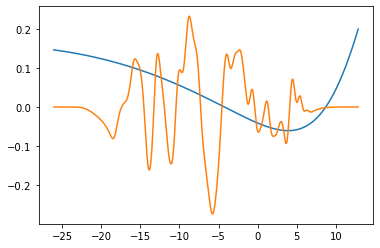

In [338]:
%matplotlib inline
plt.plot(xdos, p_dos)
plt.plot(xdos, y_pw[0])

In [324]:
xdos_pred

[tensor([ -5.6775,  -5.6775,   8.9414,   8.9414, -22.8997, -22.8997, -16.4914,
         -16.4914,   2.9336,   2.9336, -14.9895, -14.9895, -14.5889, -14.5889,
          -6.7789,  -6.7789,  -2.5234,  -2.5234, -21.4978, -21.4978,   3.5845,
           3.5845,   4.9863,   4.9863, -24.7520, -24.7520,  11.1442,  11.1442,
         -12.4362, -12.4362, -16.0408, -16.0408]),
 tensor([-17.6929, -17.6929,  -2.5735,  -2.5735,   0.7809,   0.7809, -15.1897,
         -15.1897, -15.3900, -15.3900,   1.1313,   1.1313,  -9.5825,  -9.5825,
          10.4433,  10.4433, -17.8932, -17.8932, -20.2963, -20.2963,  -9.5324,
          -9.5324, -25.8535, -25.8535,   9.1917,   9.1917, -14.5389, -14.5389,
           9.7424,   9.7424,   3.7347,   3.7347]),
 tensor([ -2.4233,  -2.4233, -15.2898, -15.2898, -21.1474, -21.1474,  -5.2769,
          -5.2769,  -1.7224,  -1.7224, -25.8034, -25.8034,   5.8374,   5.8374,
          -6.8289,  -6.8289,   2.6833,   2.6833,   5.5370,   5.5370, -18.4439,
         -18.4439, -20.7969, 

## Making a basic NN


In [19]:
import dostools.src.models.models as models
import dostools.src.models.training as training
import dostools.src.models.architectures as architecture
import dostools.src.loss.loss as loss
import torch.nn as nn

importlib.reload(models)
importlib.reload(training)
importlib.reload(architecture)
importlib.reload(loss)



class testNN(torch.nn.Module):
    
    def __init__(self, input_dims, L1, L2, target_dims, xdos):
        super(testNN, self).__init__()
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.fc1 = torch.nn.Linear(input_dims, L1)
        self.fc2 = torch.nn.Linear(L1,L2)
        self.fc3 = torch.nn.Linear(L2, target_dims)
        self.silu = torch.nn.Sigmoid()
        self.xdos = xdos
    def forward(self, x):
        
        
        x = self.fc1(x)
        x = self.silu(x)
        x = self.fc3(x)
        x = self.silu(x)
        return x
        
        x = self.fc2(x)
        x = self.silu(x)
        x = self.fc3(x)
        
        return x
    
    def fit(self, loss, lr ,n_epochs):
        """
        Fits the model based on the training data, early stopping is based on performance on training data (or validation data)
        Returns the loss history 
        
        Args:
            traindata_loader (DataLoader): Train dataloader
            valdata_loader (DataLoader): Validation dataloader
            loss (function): Loss function
            lr (float): Learning rate
            n_epochs (int): Max number of epochs
        
        Returns:
            list: Loss history of the training process
        """
        opt = torch.optim.Adam(self.parameters(), lr = lr)
        best_state = copy.deepcopy(self.state_dict())
        lowest_loss = torch.tensor(9999)
        pred_loss = torch.tensor(0)
        trigger = 0
        loss_history = []
        pbar = tqdm(range(n_epochs))
        fig, ax_list = plt.subplots(2,1)
        lines = []
        for i in range(1):
            line, = ax_list[i].plot(self.xdos.cpu(), ldos[0], label = "Prediction")
            lines.append(line)
            ax_list[i].plot(self.xdos.cpu(), ldos[0], label = "True")
        ax_list[0].legend()
        fig.show()
        for epoch in pbar:
            pbar.set_postfix(pred_loss = pred_loss.item())
            self.train()          
            opt.zero_grad()           
            
            pred = self.forward(xdos.view(-1,1))
            pred_loss = loss(pred, ldos[0].view(-1,1))
            new_loss = pred_loss
            pred_loss.backward()
            opt.step()
            if pred_loss >100000 or (pred_loss.isnan().any()) :
                print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
                self.load_state_dict(best_state)
                opt = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = self.reg.item())
            if epoch %3 == 1:
                loss_history.append(lowest_loss.item())
            for i in range(1):
                #lines[i].set_ydata(structure_results[i].detach().cpu())
                lines[i].set_ydata(pred.detach().cpu())
            ax_list[0].set_title("Epochs: {}, Pred loss: {}".format(epoch, pred_loss.item()))
            fig.canvas.draw()
            fig.canvas.flush_events()
            fig.show()
            time.sleep(0.1)

        return loss_history  

  0%|                                                                                                                                                                          | 0/1000000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


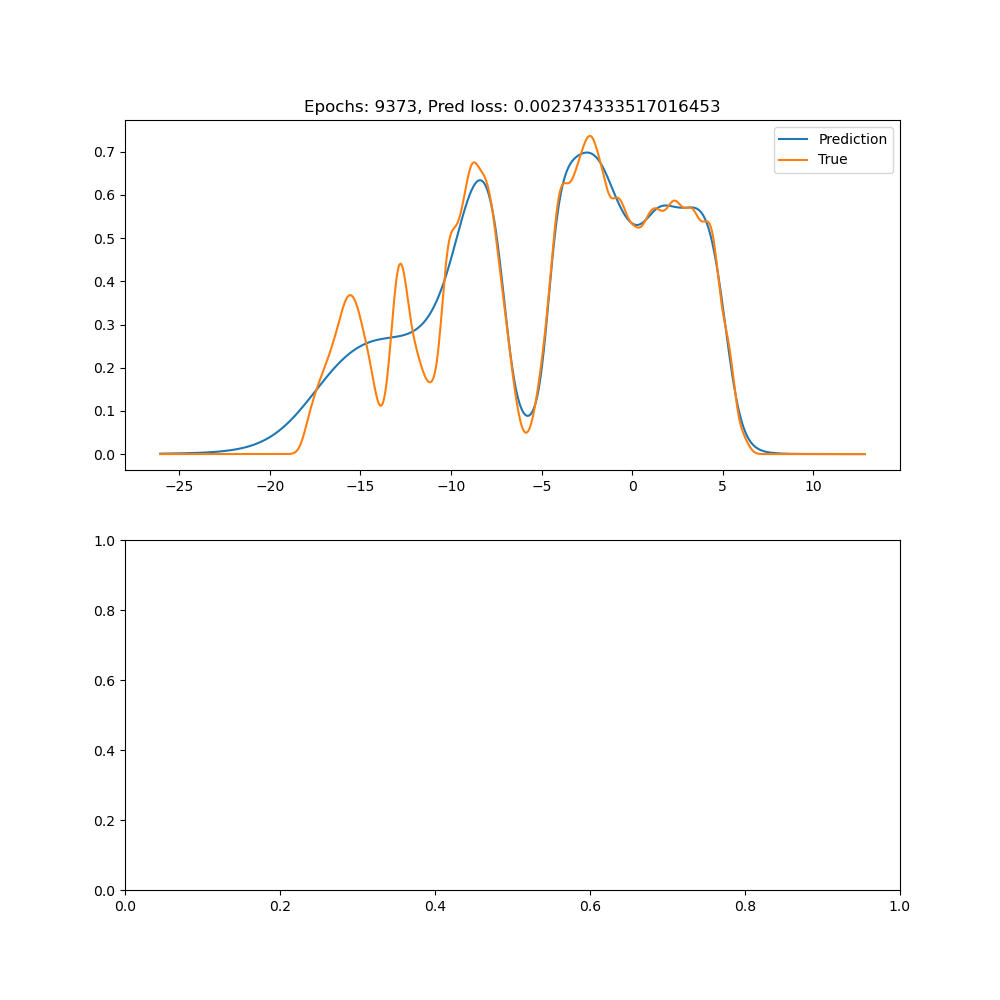

  1%|█▎                                                                                                                                       | 9373/1000000 [37:31<67:47:12,  4.06it/s, pred_loss=0.00238]

In [ ]:
xdos_step = xdos[1] - xdos[0]
testmodel = testNN(1, 100, 100, 1, xdos)
testmodel.fit(t_get_mse, 0.001, 1000000)

In [ ]:
N_xdos = (xdos - xdos.mean(0))/xdos.std()
N_xdos.shape

<IPython.core.display.Javascript object>


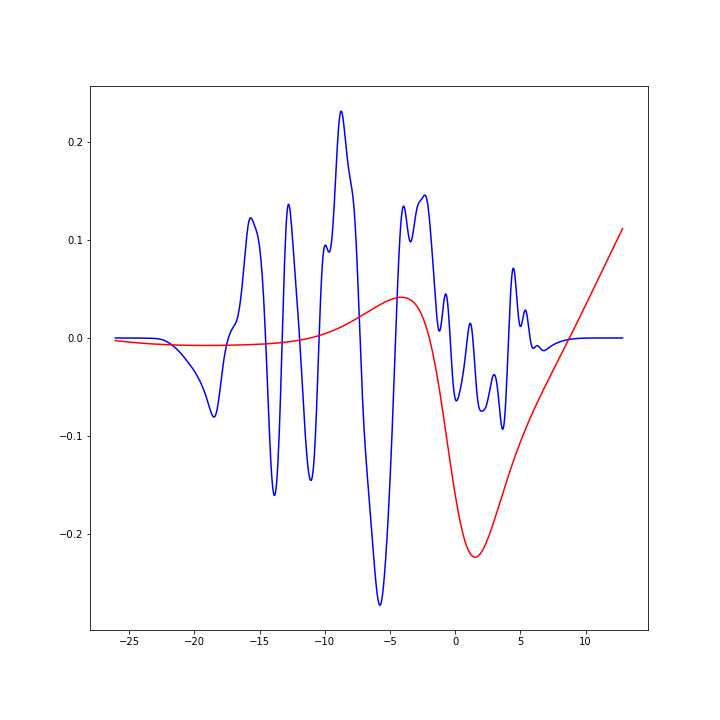

In [385]:
for x_data, y_data, index in dataloader:
    pred = model(x_data)
    structure_results = torch.zeros_like(y_data)
    structure_results = structure_results.index_add_(0, index, pred)
    
plt.plot(xdos, y_data[0], color = 'b')
plt.plot(xdos, structure_results[0].detach().numpy(), color = 'r')

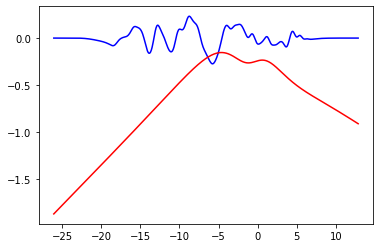

In [342]:
for x_data, y_data, index in dataloader:
    pred = model(x_data)
    structure_results = torch.zeros_like(y_data)
    structure_results = structure_results.index_add_(0, index, pred)
    
plt.plot(xdos, y_data[0], color = 'b')
plt.plot(xdos, structure_results[0].detach().numpy(), color = 'r')

In [350]:
for x_data, y_data, index in dataloader:
    pred = x_data
    structure_results = torch.zeros_like(x_data)
    structure_results = structure_results.index_add_(0, index, pred)

In [447]:
import dostools.src.models.models as models
import dostools.src.models.training as training
import dostools.src.models.architectures as architecture
import dostools.src.loss.loss as loss
import torch.nn as nn

importlib.reload(models)
importlib.reload(training)
importlib.reload(architecture)
importlib.reload(loss)



class CDNN(torch.nn.Module):
    
    def __init__(self, input_dims, L1, L2, target_dims, xdos, dropout, reg, opt, device):
        super(CDNN, self).__init__()
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.fc1 = torch.nn.Linear(1, L1)
        self.fc2 = torch.nn.Linear(L1, target_dims)
        self.silu = torch.nn.SiLU()
        self.xdos = xdos
        #self.dropout = torch.nn.Dropout(p = dropout)
        self.device = device
        self.reg = torch.tensor(reg).to(self.device)
        self.opt = opt
        self.to(self.device)
        
    def forward(self, x):
        
#         result = self.fc1(torch.hstack([x,(E*100).repeat(x.shape[0])[:,None]]))
#         result = self.silu(result)
#         result = self.fc2(result)
        
#         return result
        results = []
        for i, E in enumerate(torch.nn.functional.normalize(self.xdos, dim =0)):
            #result = self.fc1(torch.hstack([x,(E*100).repeat(x.shape[0])[:,None]]))
            
            result = self.fc1((E).repeat(x.shape[0]).view(-1,1))
            result = self.silu(result)
            result = self.fc2(result)
            results.append(result)
        results = torch.hstack(results)

        
#         x = self.fc1(x)
#         x = self.dropout(x)
#         x = self.gelu(x)
#         x = self.fc2(x)
#         x = self.dropout(x)
#         x = self.gelu(x)        
#         x = self.fc3(x)
        #x = self.gelu(x)
        
        return results
    
    def fit(self, traindata_loader, valdata_loader, loss, lr ,n_epochs):
        """
        Fits the model based on the training data, early stopping is based on performance on training data (or validation data)
        Returns the loss history 
        
        Args:
            traindata_loader (DataLoader): Train dataloader
            valdata_loader (DataLoader): Validation dataloader
            loss (function): Loss function
            lr (float): Learning rate
            n_epochs (int): Max number of epochs
        
        Returns:
            list: Loss history of the training process
        """
        if self.opt == "Adam":
            opt = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = self.reg.item())
            if valdata_loader is not None:
                threshold = 2000
                scheduler_threshold = 2000
            else:
                threshold = 200
                scheduler_threshold = 20
            tol = 1e-2
        if self.opt == "LBFGS":
            opt = torch.optim.LBFGS(self.parameters(), lr = lr)
            if valdata_loader is not None:
                threshold = 2000
                scheduler_threshold = 2000
            else:
                threshold = 30
                scheduler_threshold = 25
            tol = 1e-2
        scheduler = torch.optim.lr_scheduler.StepLR(opt, scheduler_threshold, gamma = 0.5)
        best_state = copy.deepcopy(self.state_dict())
        lowest_loss = torch.tensor(9999)
        pred_loss = torch.tensor(0)
        trigger = 0
        loss_history =[]
        pbar = tqdm(range(n_epochs))
        fig, ax_list = plt.subplots(2,1)
        lines = []
        for i in range(1):
            line, = ax_list[i].plot(self.xdos.cpu(), traindata_loader.dataset.y[i], label = "Prediction")
            lines.append(line)
            ax_list[i].plot(self.xdos.cpu(), traindata_loader.dataset.y[i], label = "True")
        ax_list[0].legend()
        fig.show()
        for epoch in pbar:
            pbar.set_postfix(pred_loss = pred_loss.item(), lowest_loss = lowest_loss.item(), trigger = trigger)
            self.train()          
#             if self.opt == "LBFGS":
#                 def closure():
#                     opt.zero_grad()
#                     _atomic_results = []
#                     for x_data in traindata_loader:
#                         x_data = x_data.to(self.device).double()
#                         _pred = self.forward(x_data)
#                         _atomic_results.append(_pred)
#                     _atomic_results = torch.vstack(_atomic_results).to(self.device)
#                     _structure_results = torch.zeros_like(traindata_loader.dataset.y).to(self.device)
#                     _structure_results = _structure_results.index_add_(0, traindata_loader.dataset.index.to(self.device), _atomic_results)
#                     _pred_loss = loss(_structure_results, traindata_loader.dataset.y.to(self.device), self.xdos, perc = True)
#                     #_reg_loss = torch.sum(torch.pow(self.fc1.weight,2)) + torch.sum(torch.pow(self.fc2.weight,2)) + torch.sum(torch.pow(self.fc3.weight,2))
#                     _new_loss = _pred_loss #+ _reg_loss
#                     _new_loss.backward()
#                     return _new_loss
#                 opt.step(closure)
#                 with torch.no_grad():
#                     self.eval()
#                     atomic_results = []
#                     for x, y, index in traindata_loader:
#                         x = x.to(self.device).double()
#                         pred = self.forward(x)
#                         atomic_results.append(pred)
#                     atomic_results = torch.vstack(atomic_results).to(self.device)
#                     structure_results = torch.zeros_like(traindata_loader.dataset.y).to(self.device)
#                     structure_results = structure_results.index_add_(0, traindata_loader.dataset.index.to(self.device), atomic_results)
#                     pred_loss = loss(structure_results, traindata_loader.dataset.y.to(self.device), self.xdos, perc = True)
#                     #reg_loss = torch.sum(torch.pow(self.fc1.weight,2)) + torch.sum(torch.pow(self.fc2.weight,2)) + torch.sum(torch.pow(self.fc3.weight,2))
#                     new_loss = pred_loss# + reg_loss
#                     if pred_loss >100000 or (pred_loss.isnan().any()) :
#                         print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
#                         self.load_state_dict(best_state)
#                         opt = torch.optim.LBFGS(self.parameters(), lr = lr)
#                     if epoch %10 == 1:
#                         loss_history.append(lowest_loss.item())
#                     #Updating Figures here
#                     for i in range(4):
#                         lines[i].set_ydata(structure_results[i].cpu())
                    
#                     ax_list[0].set_title("Epochs: {}, Pred loss: {}, Lowest loss:{}, Trigger: {}".format(epoch, pred_loss.item(), lowest_loss.item(), trigger))
#                     fig.canvas.draw()
#                     fig.canvas.flush_events()
#                     time.sleep(0.1)
#                     print ("Done one epoch")
            if self.opt == "Adam":
                opt.zero_grad()                
                for x_data, y_data, index in traindata_loader:
#                         for E in E_shuffled:
#                             pred = self.forward(x_data, self.xdos[E])                    
#                             structure_results = torch.sum(pred, dim = 0)
#                             #structure_results = torch.zeros_like(y_data).to(self.device)
#                             #structure_results = structure_results.index_add_(0, index.to(self.device), pred)
#                             pred_loss = loss(structure_results, y_data[0][E])#, self.xdos, perc = False)
#                             new_loss = pred_loss
#                             pred_loss.backward()
#                             opt.step()
#                     with torch.no_grad():
#                         structure_results = []
#                         for x in self.xdos:
#                             structure_results.append(self.forward(x_data, x))
#                         structure_results = torch.hstack(structure_results)
#                         structure_results = torch.sum(structure_results, dim =0)
#                         pred_loss = loss(structure_results, y_data)
#                         new_loss = pred_loss
                    pred = self.forward(x_data)                    
                    structure_results = torch.sum(pred, dim = 0)
                    #structure_results = torch.zeros_like(y_data).to(self.device)
                    #structure_results = structure_results.index_add_(0, index.to(self.device), pred)
                    pred_loss = loss(structure_results, y_data)#, self.xdos, perc = False)
                    new_loss = pred_loss
                    pred_loss.backward()
                    opt.step()
                    if pred_loss >100000 or (pred_loss.isnan().any()) :
                        print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
                        self.load_state_dict(best_state)
                        opt = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = self.reg.item())
                    if epoch %3 == 1:
                        loss_history.append(lowest_loss.item())
                    for i in range(1):
                        #lines[i].set_ydata(structure_results[i].detach().cpu())
                        lines[i].set_ydata(structure_results.detach().cpu())
                    ax_list[0].set_title("Epochs: {}, Pred loss: {}, Lowest loss:{}, Trigger: {}".format(epoch, pred_loss.item(), lowest_loss.item(), trigger))
                    fig.canvas.draw()
                    fig.canvas.flush_events()
                    fig.show()
                    time.sleep(0.1)
                    #print ("Done one epoch")

                
                
#                 for i in range(4):
#                     ax_list[i].clear()
#                     ax_list[i].plot(self.xdos.cpu(), structure_results[i].detach().cpu(), label = "Prediction")
#                     ax_list[i].plot(self.xdos.cpu(), traindata_loader.dataset.y[i], label = "True")
#                 ax_list[3].legend()
#                 ax_list[0].set_title("Epochs: {}, Pred loss: {}, Lowest loss:{}, Trigger: {}".format(epoch, pred_loss.item(), lowest_loss.item(), trigger))
#                 fig.show()
            with torch.no_grad():
                if valdata_loader is not None:
                    self.eval()
                    with torch.no_grad():
                        new_loss = torch.zeros(1, requires_grad = False).to(self.device)
                        for x_val, y_val in valdata_loader:
                            x_val, y_val = x_val.to(self.device), y_val.to(self.device)
                            val_pred = self.forward(x_val)
                            new_loss += loss(val_pred, y_val, self.xdos, perc = False)

                if lowest_loss - new_loss > tol: #threshold to stop training
                    best_state = copy.deepcopy(self.state_dict())
                    lowest_loss = new_loss
                    trigger = 0

                else:
                    trigger +=1
                    scheduler.step()
                    lr = scheduler.get_last_lr()[0]
                    if trigger > threshold:
                        self.load_state_dict(best_state)
                        print ("Implemented early stopping with lowest_loss: {}".format(lowest_loss))
                        return loss_history
        return loss_history  